## Error and Correlation from all 3 models for PHOTO 50 images

In [1]:
# ## Uncomment if using Google Colab and upload file dataTop50.xlsx
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [1]:
# Initialize these:

path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads"  #<Replace the path here>
filepath = 'dataPhoto50.xlsx'
strtInd = [0, 2900, 5800, 8700, 11600, 14500, 17400, 20300, 23200, 26100, 29000, 31900, 34800]

sz = 100

In [2]:
 # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
colNames = ["col_"+str(i) for i in range(58)] 
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']

# Read data
# Get the color ratings data -From file data_clean.csv
data = pd.read_csv("data_clean.csv",names = colNames)

# Get the LAB coordinates of colors from file LabOrig.csv
#colorData = pd.read_csv("LabOrig.csv",header=None)
colorData = pd.read_csv("Lab.csv",header=None)
colorDataRGB = pd.read_csv("RGB.csv",header=None)


In [4]:
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(34800, 187)

In [5]:
X = np.copy(Q[:,:-1])
y = np.copy(Q[:,-1])
print(X.shape, y.shape)

(34800, 186) (34800,)


In [6]:
# Function to computer error, correlation and rating for LOO fruit category 
# based on the features selected from Analysis (sparse regression)
from scipy import stats
        
def getRatings(minErrFeature):
    win0 = []
    win1 = []
    win2 = []
    xNew = np.column_stack([X[:,minErrFeature],y])
    correlation = []
    error = []

    # Linear Regression using Cross Validation
    # Leave one out cross validation -- strtInd holds the starting indices of set of fruit data 
    xTemp = np.copy(xNew)

    for i in range(len(strtInd)-1):
        # Leave one entire fruit group
        testFruit =  allConcepts[i]
        #print("\nLeaving out fruit group : ",allConcepts[i])
        testTemp = np.copy(xTemp[strtInd[i]:strtInd[i+1],:]) # Get all rows from the LOO group
        trainTemp = np.delete(xTemp,range(strtInd[i],strtInd[i+1]),0)
        row = len(trainTemp)
        #Training set
        X_train = np.column_stack([np.ones((row,1)), trainTemp[:,:-1]]) # add offset
        y_train = np.copy(trainTemp[:,-1])
        # Test set (hold out set)
        row2 = len(testTemp)
        X_test  = np.column_stack([np.ones((row2,1)), testTemp[:,:-1]]) #xTemp[row:tot,0:3]#
        y_test  = np.copy(testTemp[:,-1])


        # Create linear regression object
        regr = linear_model.LinearRegression(fit_intercept=False)
        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        print("Score is : %.2f" % regr.score(X_test, y_test))
        # The coefficients
        print('Coefficients: ', regr.coef_)
        #print('Intercept: \n', regr.intercept_)
        # The mean squared error
        print("\nMean squared error: %.4f"
              % mean_squared_error(y_test, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(y_test, y_pred))

        ############## For test purposes - Average prediction over all Images of LOO group ############
        totalTestImages = y_pred.size/58  #58N rows -> every image has 58 rows of data
        avg_pred = [np.sum([y_pred[p] for p in range(q,y_pred.size,58)])/totalTestImages for q in range(58)]

        # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
        trueRating = np.copy(y_test[0:58])

        sqErr = np.sum(pow(avg_pred - trueRating,2))
        print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)

        corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
        print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
        print("p-value %.4f" %pVal)

        error.append(sqErr)
        correlation.append(corrCoeff)
        win0.append(corrCoeff) # saves correlation for test fruit
        win1.append(trueRating) # saves true rating for test fruit
        win2.append(avg_pred)   # saves avg predicted rating for test fruit
        # Plot average color rating over all test images.
        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), avg_pred,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('Predicted color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), trueRating,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('True color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        # Scatter plot
        fig2 = plt.figure(figsize=(7,7))
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        plt.ylabel('Predicted Ratings')
        plt.xlabel('Subject Ratings')
        plt.title('Scatter plot of color ratings for : %s' %testFruit)
        plt.axis('equal')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show() 
    return error, correlation, win0, win1, win2

# Regression on top 3 spherical features

Score is : 0.44
Coefficients:  [ 0.17240726  0.34340839 -0.19496377  0.12621805]

Mean squared error: 0.0189
Variance score: 0.44
The true squared error (in color ratings) for left out fruit mango is: 0.9548

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8941
p-value 0.0000


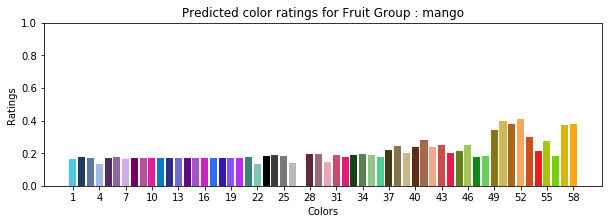

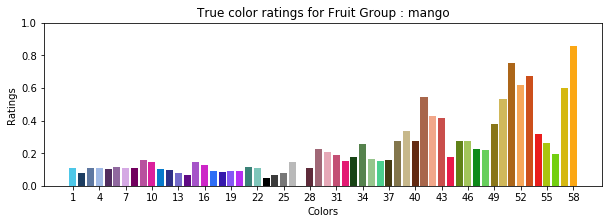

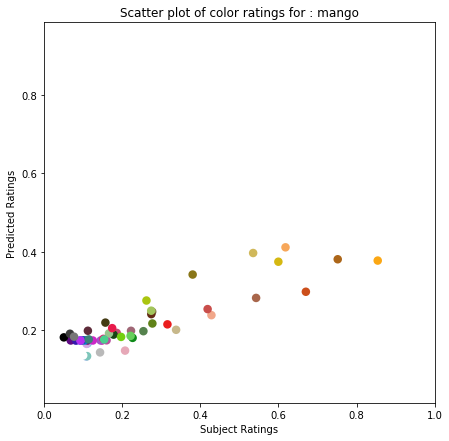

Score is : -0.02
Coefficients:  [ 0.16583934  0.36662039 -0.19766823  0.13229306]

Mean squared error: 0.0373
Variance score: -0.02
The true squared error (in color ratings) for left out fruit watermelon is: 1.9106

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4338
p-value 0.0007


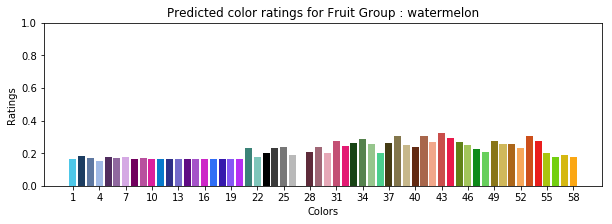

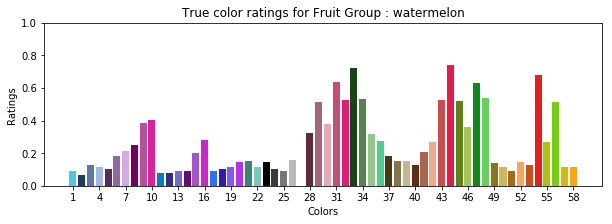

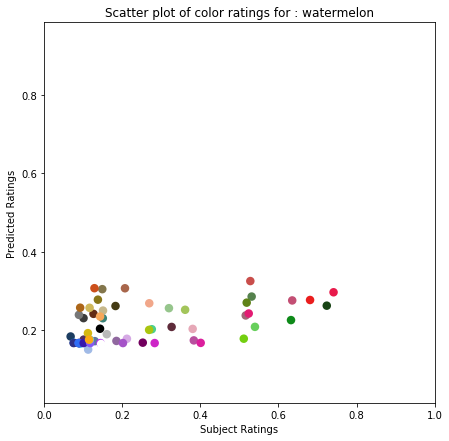

Score is : 0.39
Coefficients:  [ 0.17181752  0.36550822 -0.20077004  0.12853514]

Mean squared error: 0.0123
Variance score: 0.39
The true squared error (in color ratings) for left out fruit honeydew is: 0.5207

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7730
p-value 0.0000


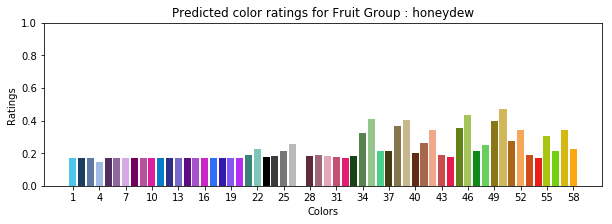

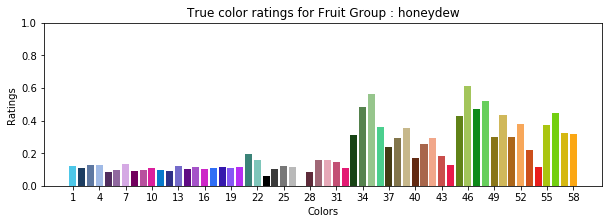

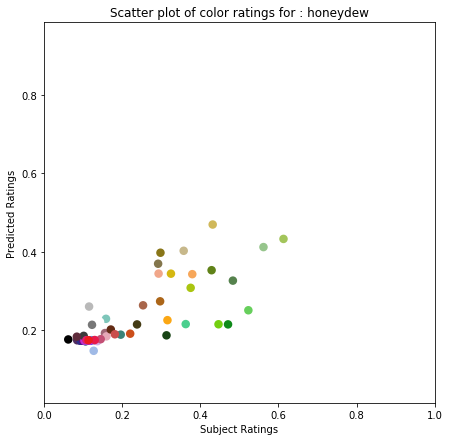

Score is : 0.48
Coefficients:  [ 0.17271787  0.35080725 -0.19286292  0.12382225]

Mean squared error: 0.0160
Variance score: 0.48
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.7314

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8707
p-value 0.0000


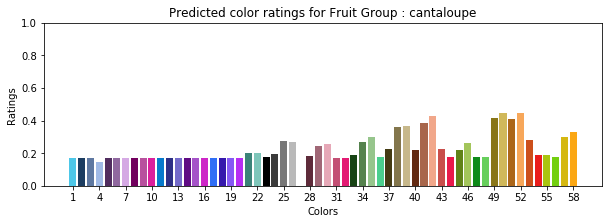

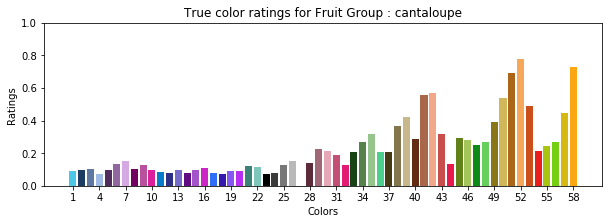

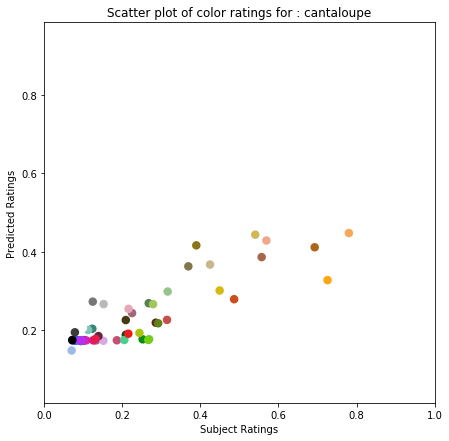

Score is : 0.32
Coefficients:  [ 0.16985157  0.35923591 -0.19516453  0.12335815]

Mean squared error: 0.0166
Variance score: 0.32
The true squared error (in color ratings) for left out fruit grapefruit is: 0.7825

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8126
p-value 0.0000


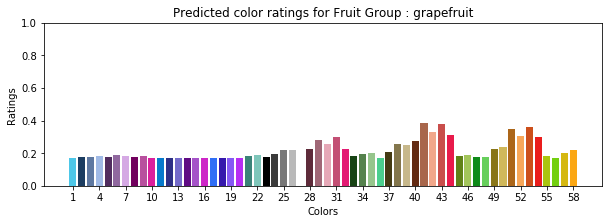

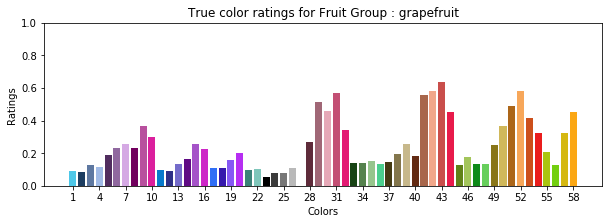

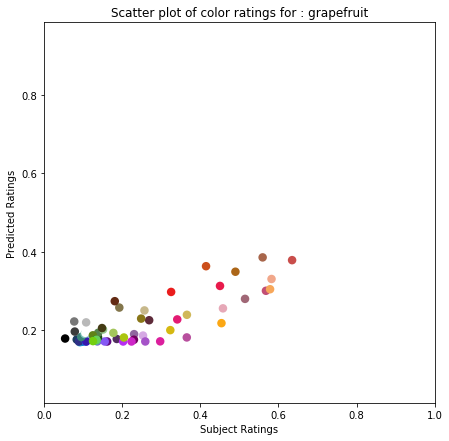

Score is : 0.13
Coefficients:  [ 0.16917793  0.35937973 -0.19720727  0.1345986 ]

Mean squared error: 0.0237
Variance score: 0.13
The true squared error (in color ratings) for left out fruit strawberry is: 1.2029

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5196
p-value 0.0000


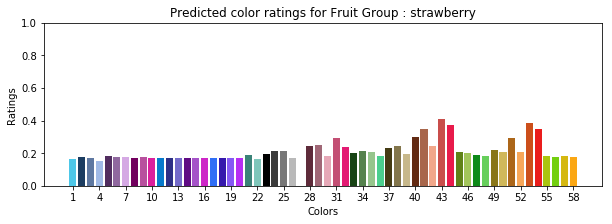

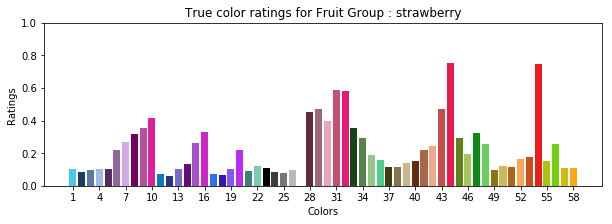

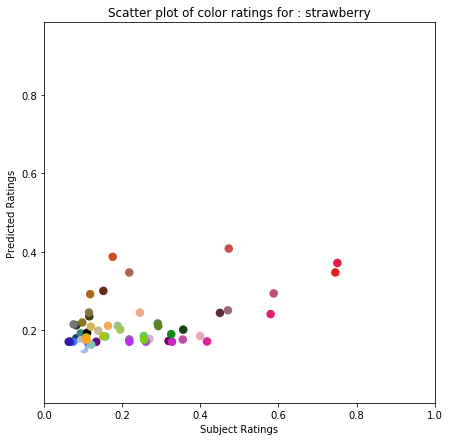

Score is : 0.10
Coefficients:  [ 0.16904707  0.36156235 -0.19200336  0.13470158]

Mean squared error: 0.0215
Variance score: 0.10
The true squared error (in color ratings) for left out fruit raspberry is: 1.0669

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4781
p-value 0.0001


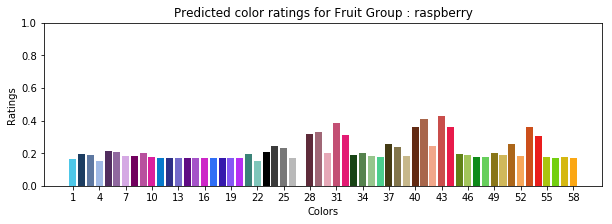

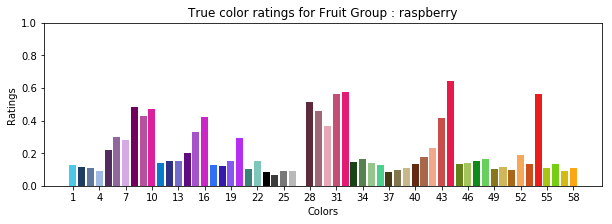

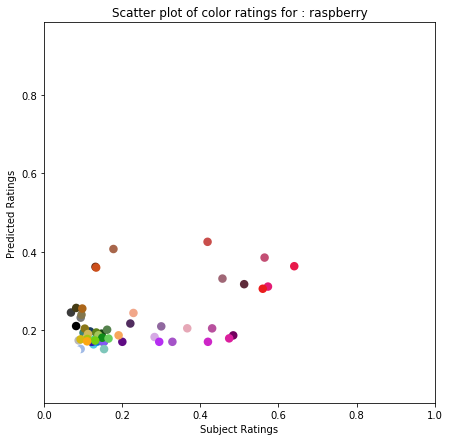

Score is : -0.01
Coefficients:  [ 0.16869149  0.37161023 -0.19611702  0.13388058]

Mean squared error: 0.0432
Variance score: -0.01
The true squared error (in color ratings) for left out fruit blueberry is: 2.3179

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.2656
p-value 0.0439


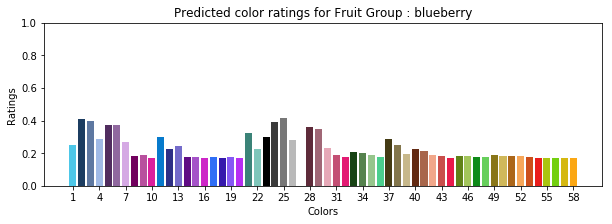

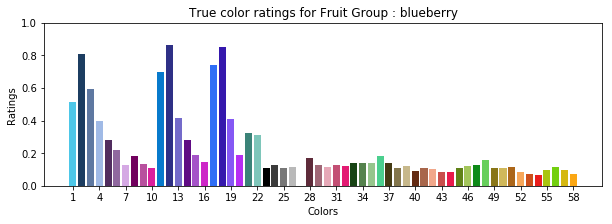

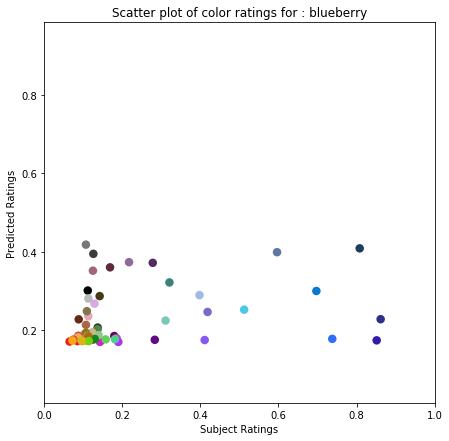

Score is : 0.15
Coefficients:  [ 0.17353997  0.37315529 -0.19479686  0.11329835]

Mean squared error: 0.0304
Variance score: 0.15
The true squared error (in color ratings) for left out fruit avocado is: 1.6242

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5199
p-value 0.0000


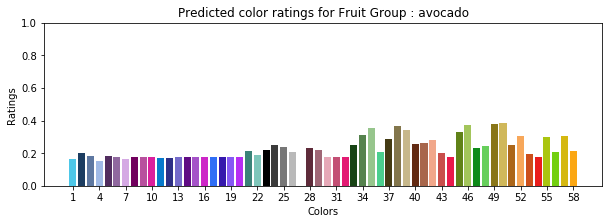

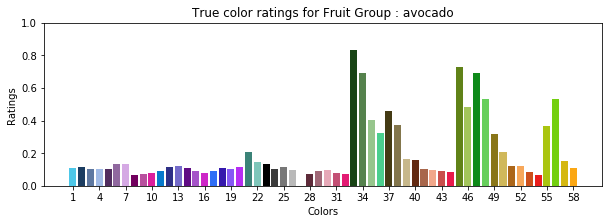

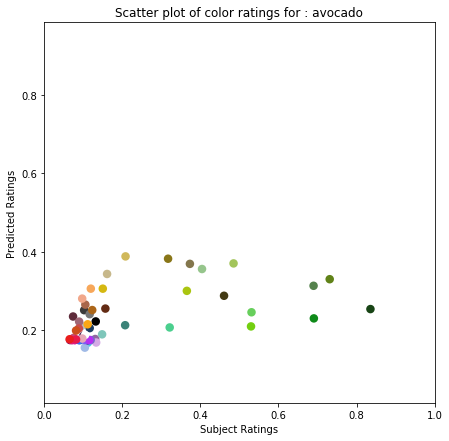

Score is : 0.44
Coefficients:  [ 0.17541563  0.34919482 -0.19612409  0.1138518 ]

Mean squared error: 0.0210
Variance score: 0.44
The true squared error (in color ratings) for left out fruit orange is: 1.0910

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9402
p-value 0.0000


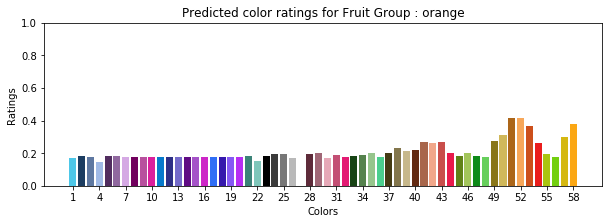

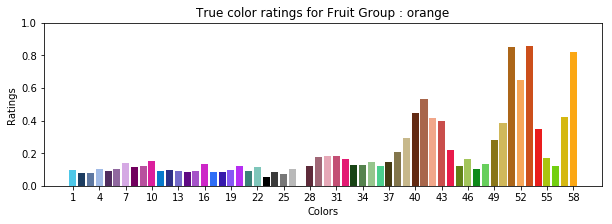

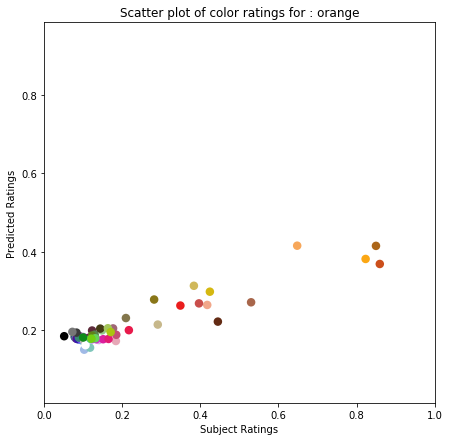

Score is : 0.08
Coefficients:  [ 0.17133567  0.36649853 -0.18468998  0.12207169]

Mean squared error: 0.0404
Variance score: 0.08
The true squared error (in color ratings) for left out fruit lime is: 2.0874

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4848
p-value 0.0001


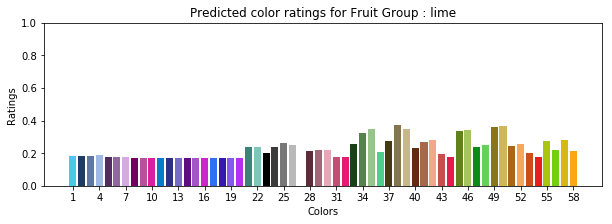

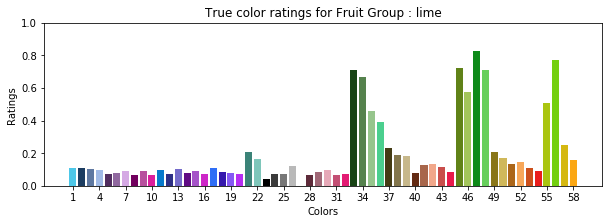

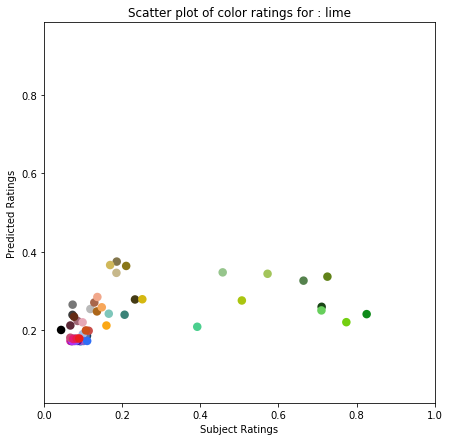

Score is : 0.33
Coefficients:  [ 0.17439991  0.34369433 -0.19101456  0.1347306 ]

Mean squared error: 0.0174
Variance score: 0.33
The true squared error (in color ratings) for left out fruit lemon is: 0.8298

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8421
p-value 0.0000


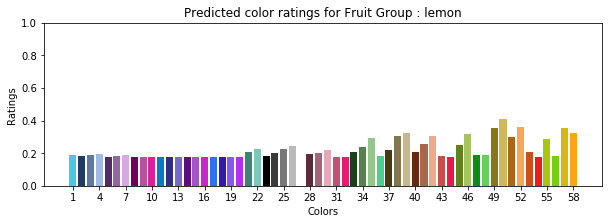

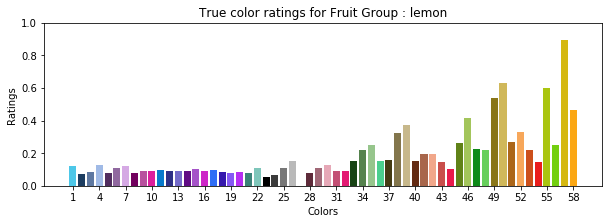

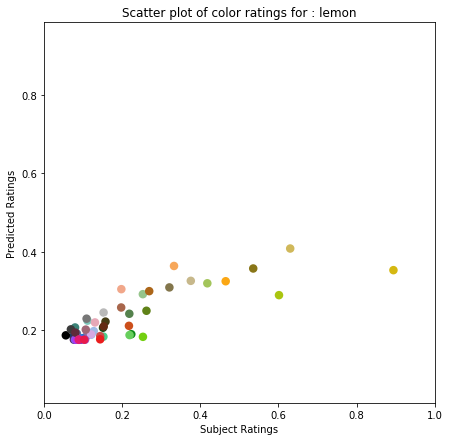

In [7]:
# Sparse features from Analysis I
minErrFeature1 = (4, 24, 29)
errSph, corrSph, win0_m1, win1_m1, win2_m1 = getRatings(minErrFeature1)

In [8]:
errSph

[0.9548338614033042,
 1.9105910197554548,
 0.5207416566111412,
 0.7314190957435098,
 0.7824647055697609,
 1.2028592575797368,
 1.0669369126440136,
 2.317873327513579,
 1.6242386748974913,
 1.0909535844688476,
 2.087369752303628,
 0.8298140277614048]

In [9]:
corrSph

[0.8941088728208133,
 0.433845130809145,
 0.7729898443073842,
 0.8707179151005738,
 0.8125534731260569,
 0.5196472582459886,
 0.47807122911294336,
 0.2656271972918551,
 0.5199319826598,
 0.9402108346932769,
 0.4848096988687117,
 0.8420972606691599]

# Regression on top 3 spherical + cyindrical features

Score is : 0.60
Coefficients:  [0.14182873 0.2098819  0.07373623 0.12431872]

Mean squared error: 0.0135
Variance score: 0.60
The true squared error (in color ratings) for left out fruit mango is: 0.6170

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9162
p-value 0.0000


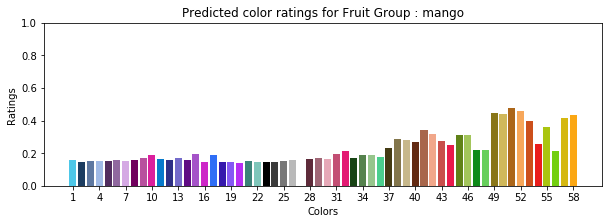

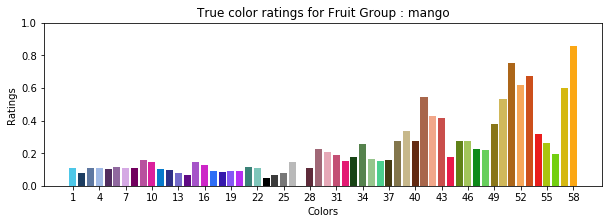

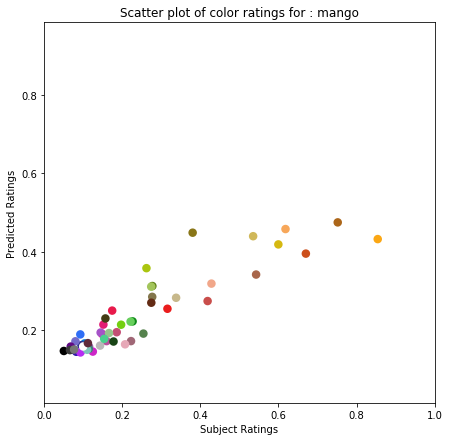

Score is : 0.03
Coefficients:  [0.13433364 0.2403021  0.05053218 0.13366635]

Mean squared error: 0.0357
Variance score: 0.03
The true squared error (in color ratings) for left out fruit watermelon is: 1.7979

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.4651
p-value 0.0002


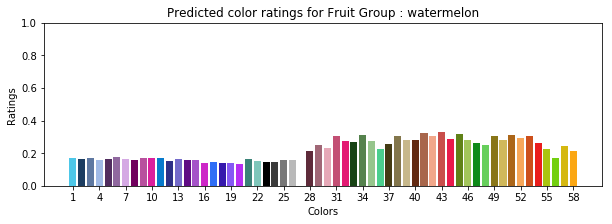

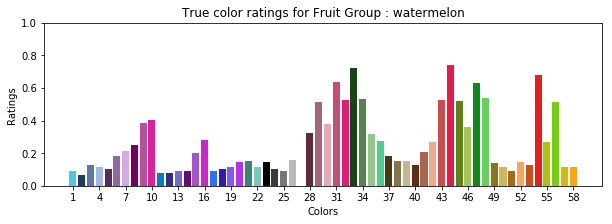

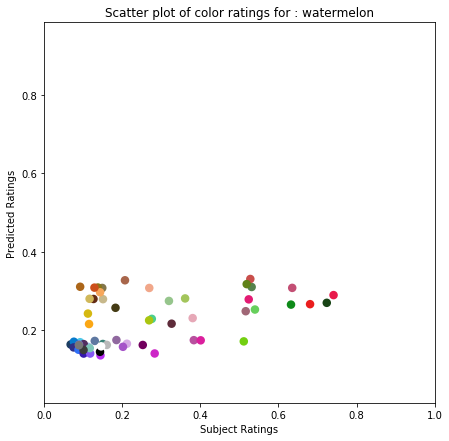

Score is : 0.52
Coefficients:  [0.13919785 0.19489143 0.11623043 0.12449491]

Mean squared error: 0.0096
Variance score: 0.52
The true squared error (in color ratings) for left out fruit honeydew is: 0.3885

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8220
p-value 0.0000


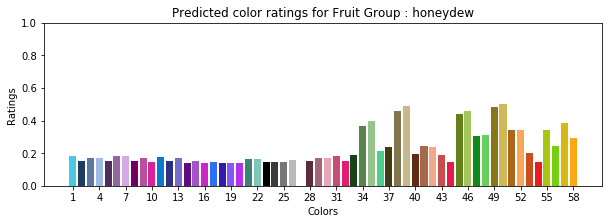

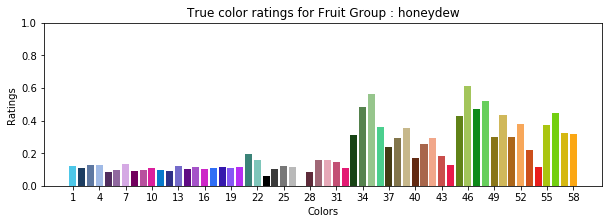

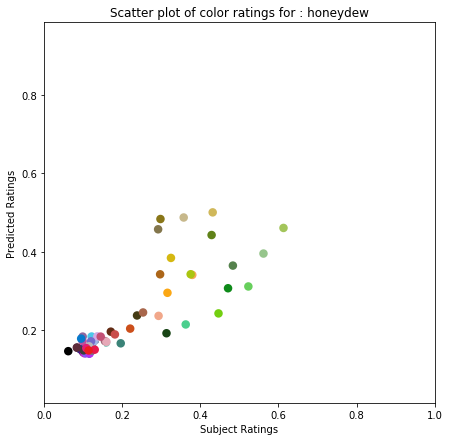

Score is : 0.61
Coefficients:  [0.1407658  0.21836687 0.07313624 0.12027101]

Mean squared error: 0.0122
Variance score: 0.61
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.5558

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8815
p-value 0.0000


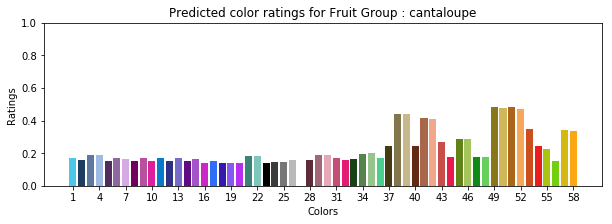

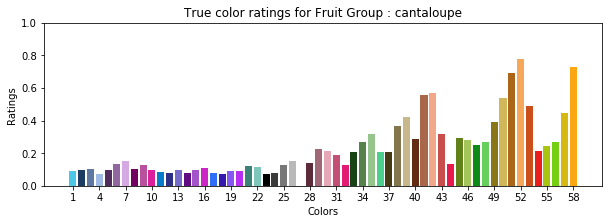

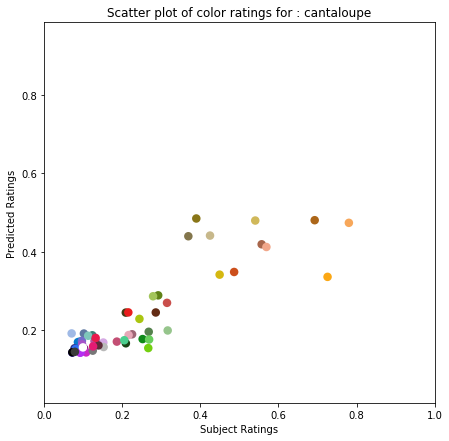

Score is : 0.45
Coefficients:  [0.13827897 0.20990501 0.10225536 0.11289075]

Mean squared error: 0.0135
Variance score: 0.45
The true squared error (in color ratings) for left out fruit grapefruit is: 0.5693

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8390
p-value 0.0000


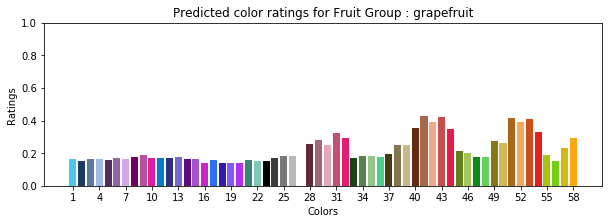

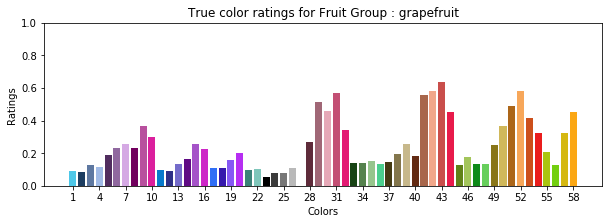

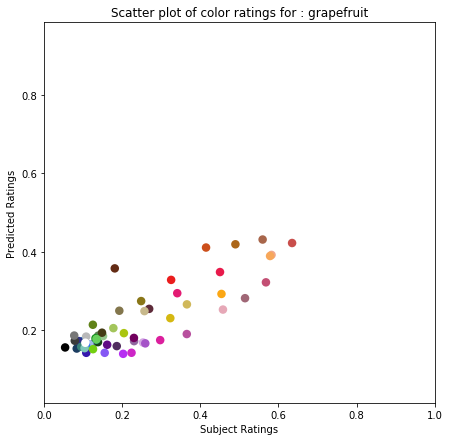

Score is : 0.19
Coefficients:  [0.13782464 0.2111813  0.08199576 0.13628733]

Mean squared error: 0.0222
Variance score: 0.19
The true squared error (in color ratings) for left out fruit strawberry is: 1.1187

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5442
p-value 0.0000


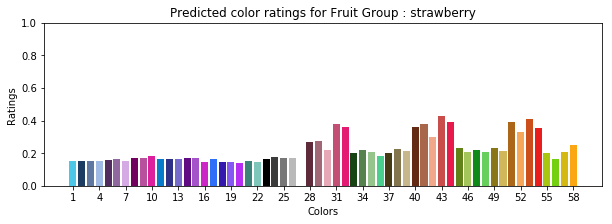

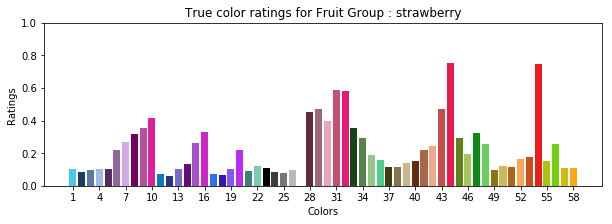

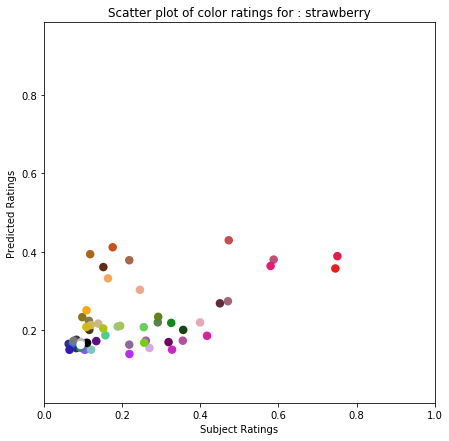

Score is : 0.10
Coefficients:  [0.13742262 0.21217172 0.08648838 0.13892478]

Mean squared error: 0.0214
Variance score: 0.10
The true squared error (in color ratings) for left out fruit raspberry is: 1.0230

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5166
p-value 0.0000


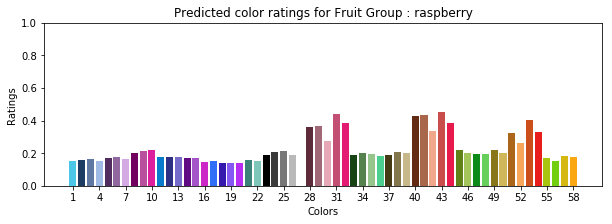

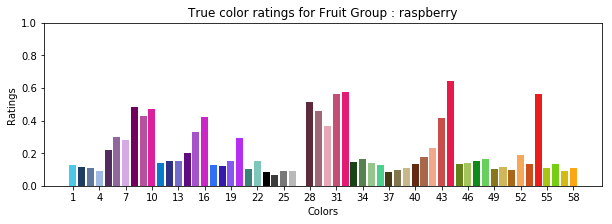

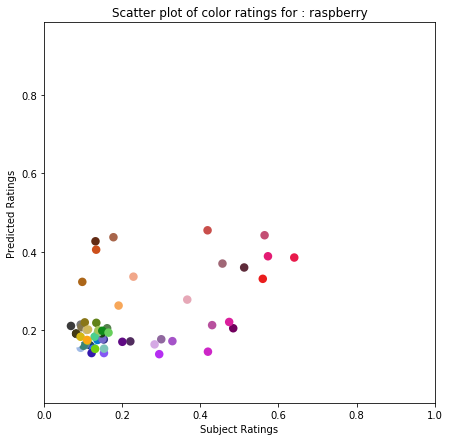

Score is : 0.12
Coefficients:  [0.13621518 0.22238031 0.07960145 0.12272141]

Mean squared error: 0.0375
Variance score: 0.12
The true squared error (in color ratings) for left out fruit blueberry is: 1.9804

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5490
p-value 0.0000


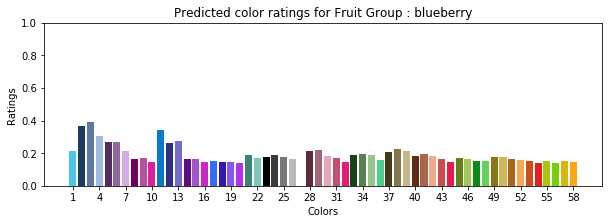

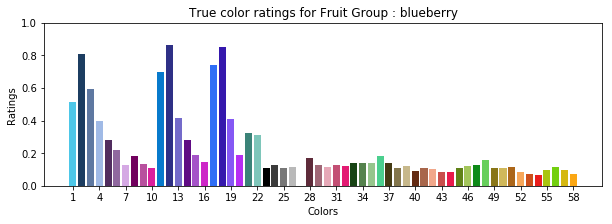

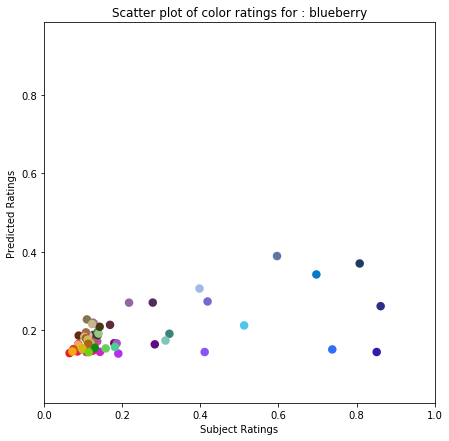

Score is : 0.28
Coefficients:  [0.14169914 0.22705146 0.09449899 0.10083767]

Mean squared error: 0.0260
Variance score: 0.28
The true squared error (in color ratings) for left out fruit avocado is: 1.3804

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6085
p-value 0.0000


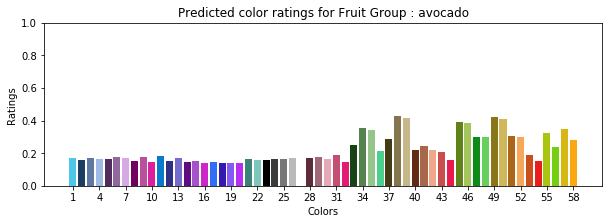

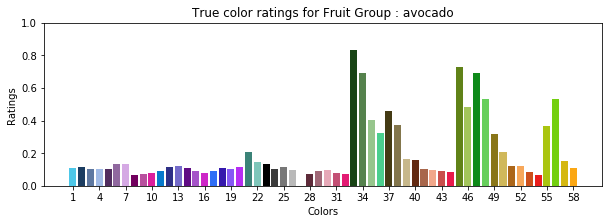

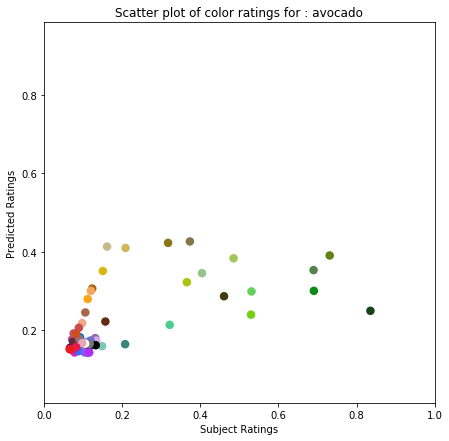

Score is : 0.57
Coefficients:  [0.14389856 0.24337815 0.03985379 0.11357459]

Mean squared error: 0.0160
Variance score: 0.57
The true squared error (in color ratings) for left out fruit orange is: 0.7835

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8928
p-value 0.0000


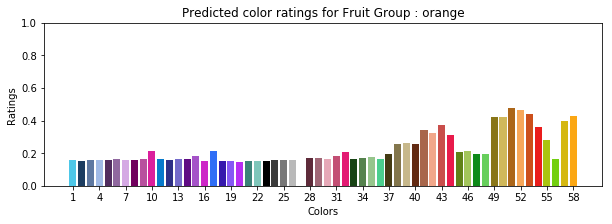

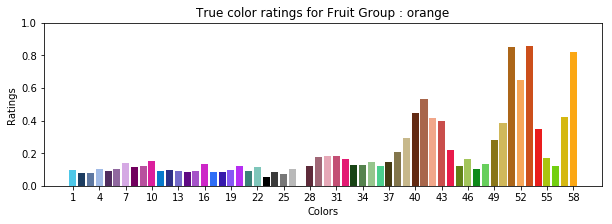

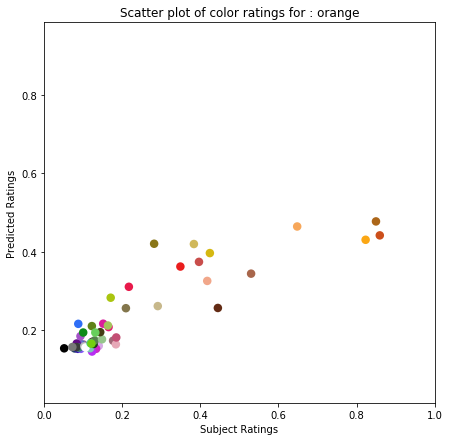

Score is : 0.19
Coefficients:  [0.14004721 0.20871294 0.09549205 0.12562902]

Mean squared error: 0.0357
Variance score: 0.19
The true squared error (in color ratings) for left out fruit lime is: 1.7931

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5814
p-value 0.0000


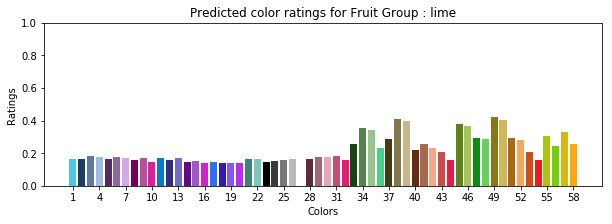

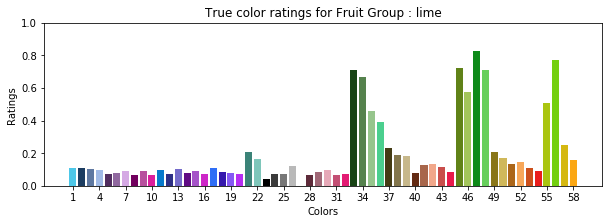

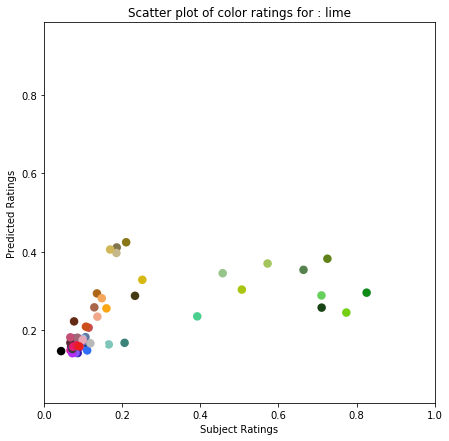

Score is : 0.48
Coefficients:  [0.14266049 0.21574439 0.07114887 0.13004789]

Mean squared error: 0.0136
Variance score: 0.48
The true squared error (in color ratings) for left out fruit lemon is: 0.5997

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8533
p-value 0.0000


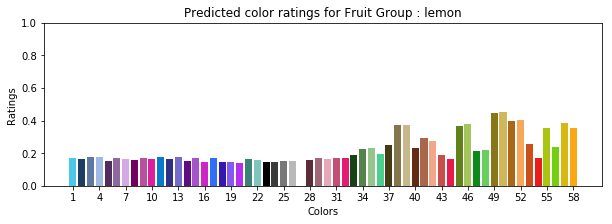

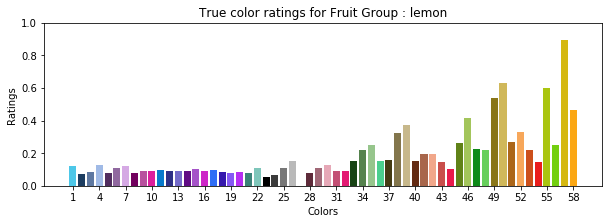

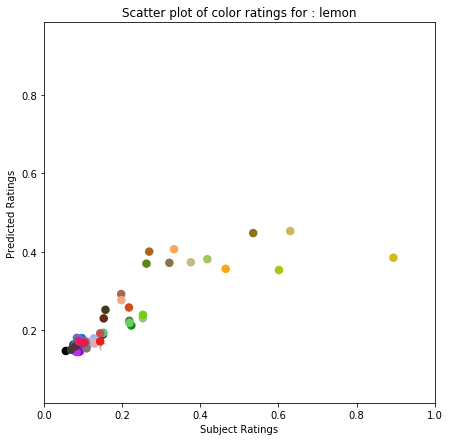

In [10]:
# Sparse features from Analysis II
minErrFeature2 = (54, 78, 179)
errSphCyl, corrSphCyl,  win0_m2, win1_m2, win2_m2 = getRatings(minErrFeature2)

# Regression on top 3 Spherical + Cylindrical + Categorical

Score is : 0.57
Coefficients:  [0.13729253 0.14075383 0.11025089 0.33043433]

Mean squared error: 0.0145
Variance score: 0.57
The true squared error (in color ratings) for left out fruit mango is: 0.6125

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9157
p-value 0.0000


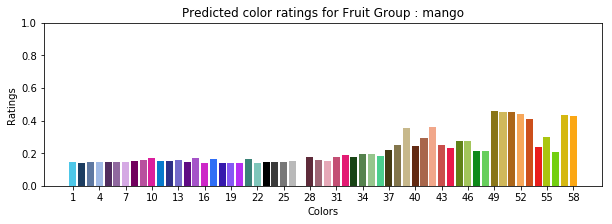

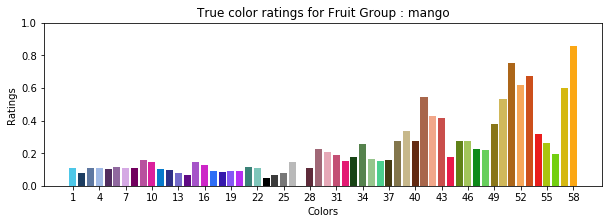

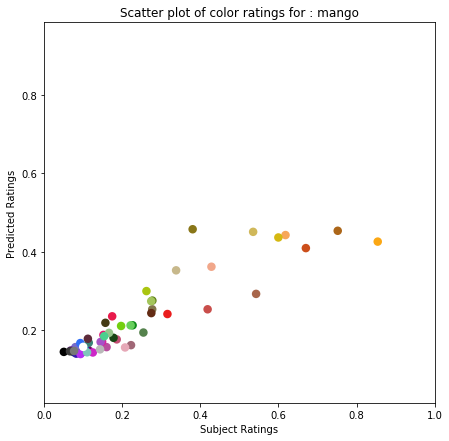

Score is : 0.12
Coefficients:  [0.13058254 0.164143   0.11741018 0.31399256]

Mean squared error: 0.0323
Variance score: 0.12
The true squared error (in color ratings) for left out fruit watermelon is: 1.4575

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6506
p-value 0.0000


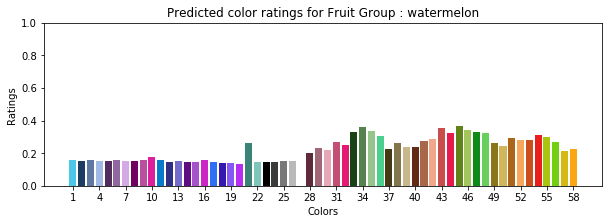

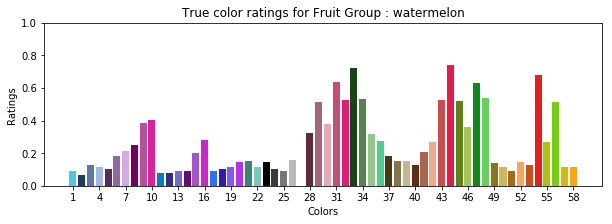

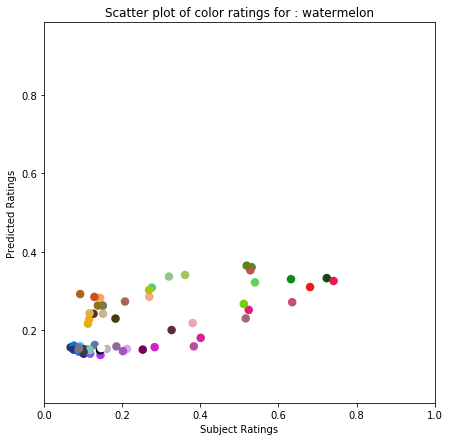

Score is : 0.56
Coefficients:  [0.13556126 0.15433668 0.11481794 0.33223521]

Mean squared error: 0.0089
Variance score: 0.56
The true squared error (in color ratings) for left out fruit honeydew is: 0.2198

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9138
p-value 0.0000


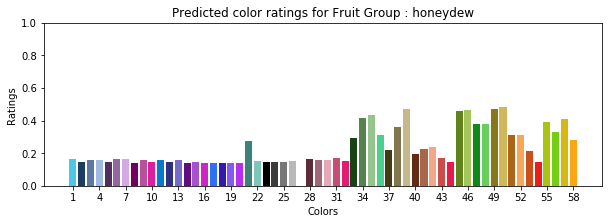

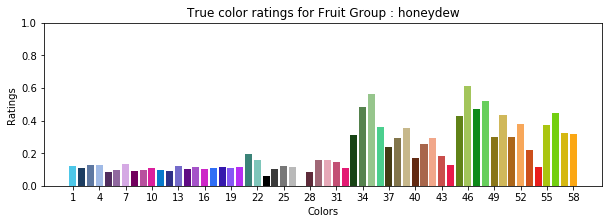

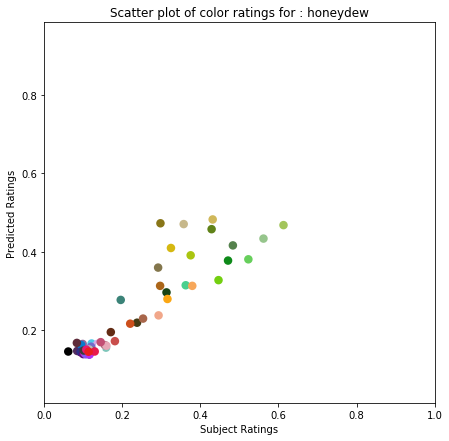

Score is : 0.65
Coefficients:  [0.13675136 0.15316615 0.10375413 0.32255818]

Mean squared error: 0.0110
Variance score: 0.65
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.4338

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9369
p-value 0.0000


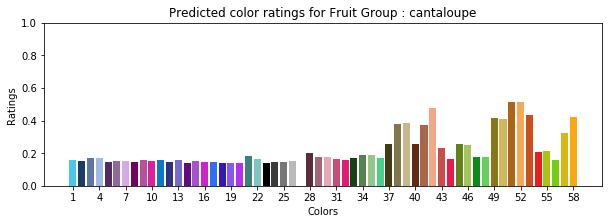

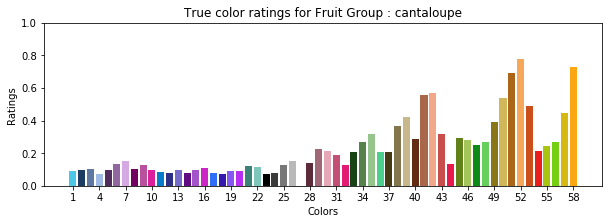

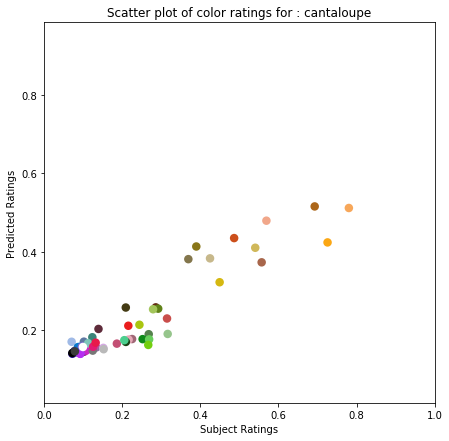

Score is : 0.38
Coefficients:  [0.13386461 0.15611599 0.10241771 0.33552327]

Mean squared error: 0.0153
Variance score: 0.38
The true squared error (in color ratings) for left out fruit grapefruit is: 0.6093

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8329
p-value 0.0000


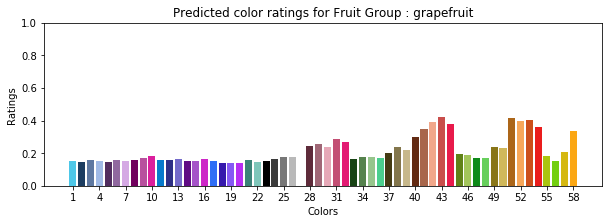

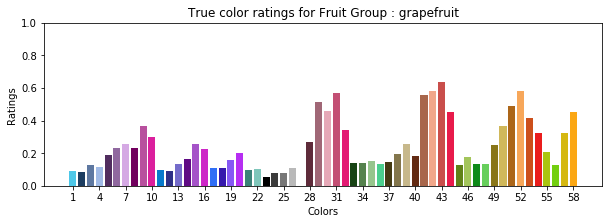

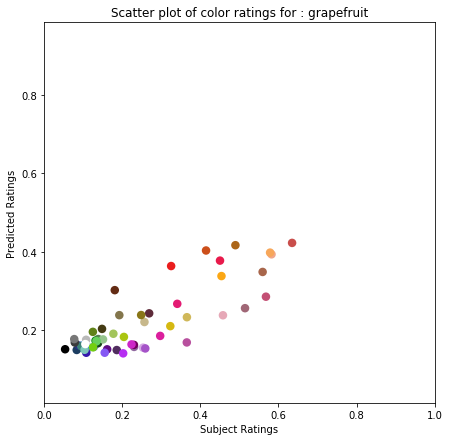

Score is : 0.28
Coefficients:  [0.13373924 0.15438374 0.12279352 0.31325803]

Mean squared error: 0.0195
Variance score: 0.28
The true squared error (in color ratings) for left out fruit strawberry is: 0.9215

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6708
p-value 0.0000


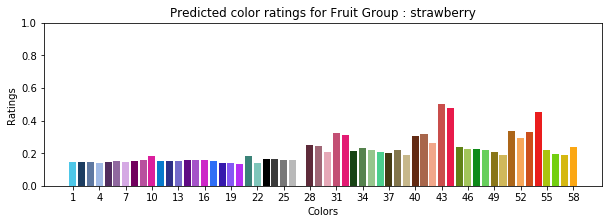

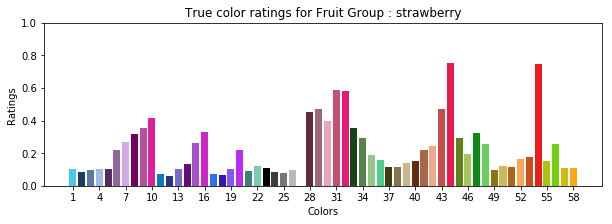

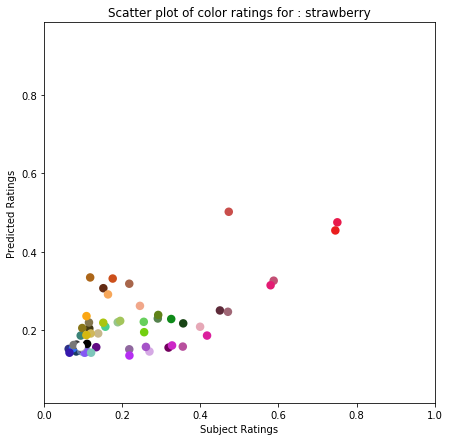

Score is : 0.17
Coefficients:  [0.13326732 0.15276691 0.12670345 0.32142811]

Mean squared error: 0.0199
Variance score: 0.17
The true squared error (in color ratings) for left out fruit raspberry is: 0.8830

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6022
p-value 0.0000


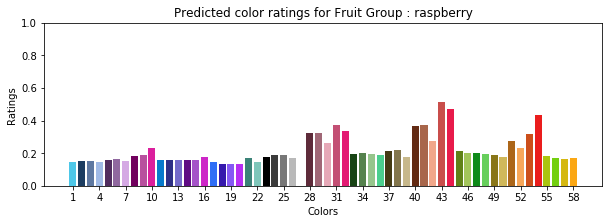

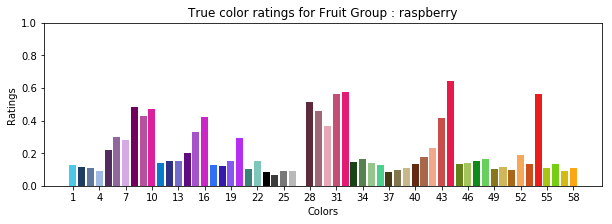

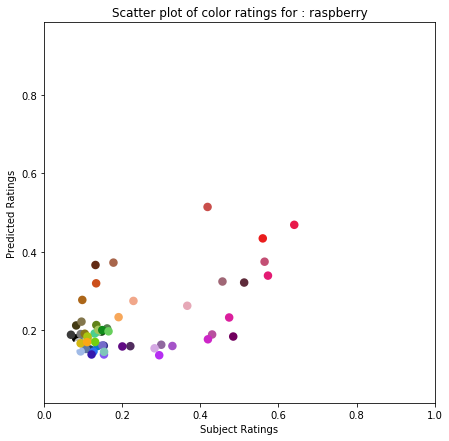

Score is : 0.37
Coefficients:  [0.13472085 0.17943573 0.1094492  0.27897358]

Mean squared error: 0.0268
Variance score: 0.37
The true squared error (in color ratings) for left out fruit blueberry is: 1.2463

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8400
p-value 0.0000


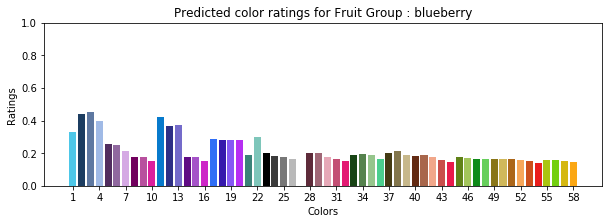

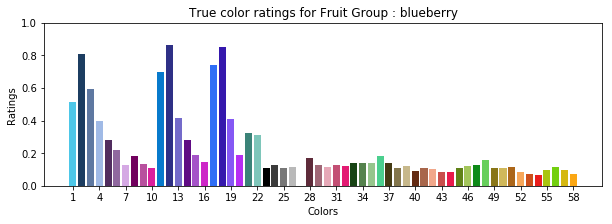

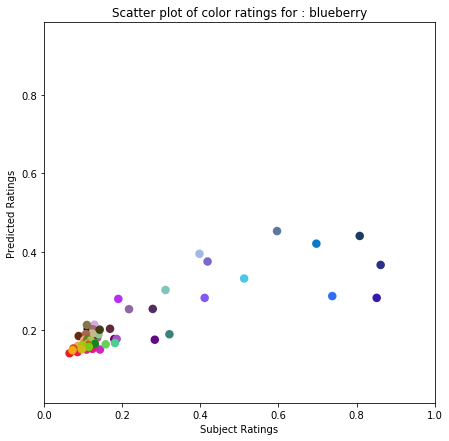

Score is : 0.37
Coefficients:  [0.13817279 0.17947912 0.09064841 0.31161289]

Mean squared error: 0.0226
Variance score: 0.37
The true squared error (in color ratings) for left out fruit avocado is: 1.0884

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7480
p-value 0.0000


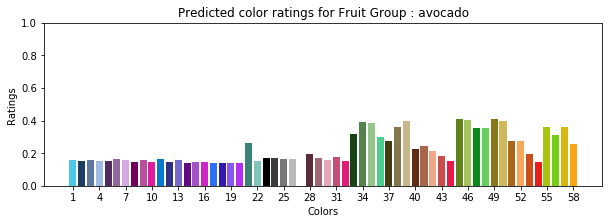

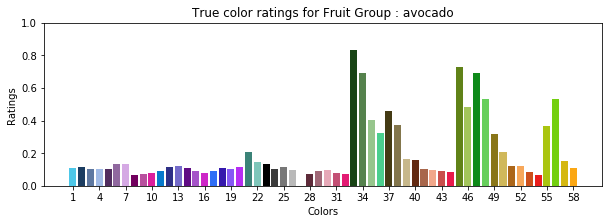

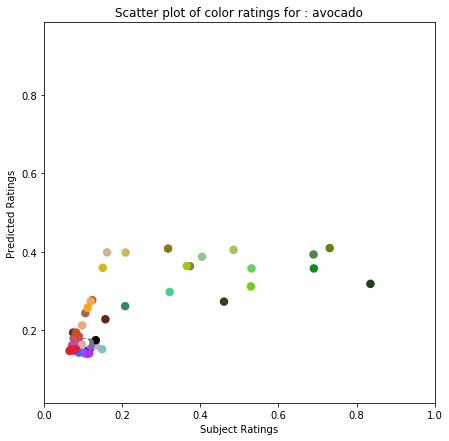

Score is : 0.66
Coefficients:  [0.13936711 0.16251968 0.09527195 0.31117372]

Mean squared error: 0.0127
Variance score: 0.66
The true squared error (in color ratings) for left out fruit orange is: 0.5570

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9426
p-value 0.0000


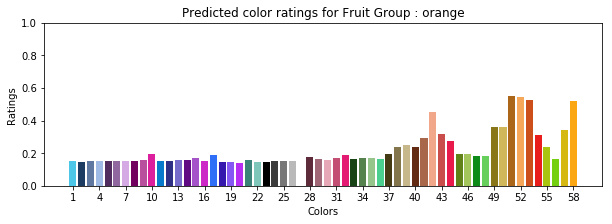

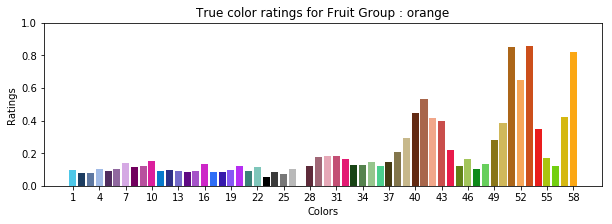

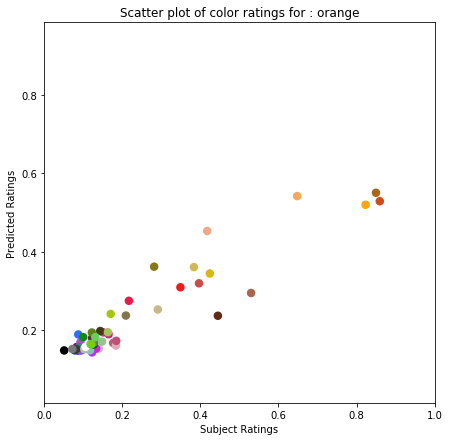

Score is : 0.32
Coefficients:  [0.13671329 0.16395402 0.11835585 0.30315947]

Mean squared error: 0.0297
Variance score: 0.32
The true squared error (in color ratings) for left out fruit lime is: 1.2694

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8080
p-value 0.0000


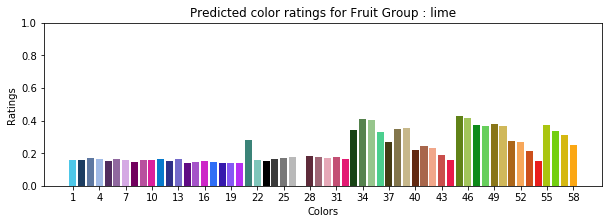

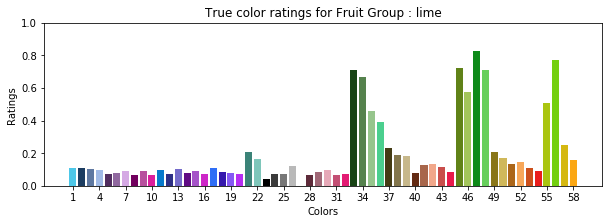

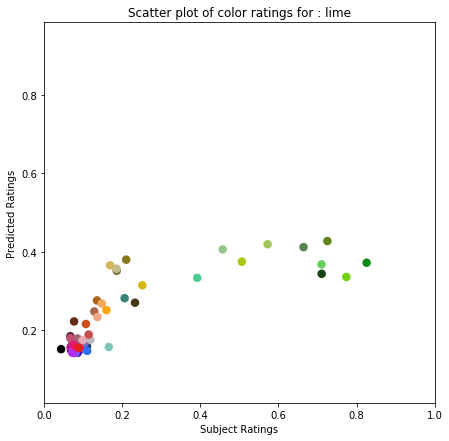

Score is : 0.46
Coefficients:  [0.13853863 0.14295303 0.11805449 0.33023838]

Mean squared error: 0.0140
Variance score: 0.46
The true squared error (in color ratings) for left out fruit lemon is: 0.5188

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8904
p-value 0.0000


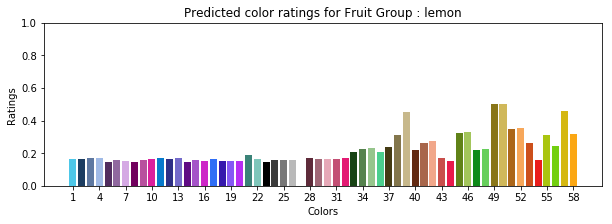

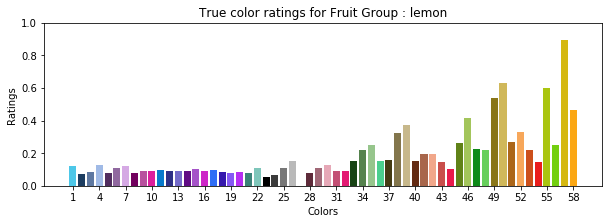

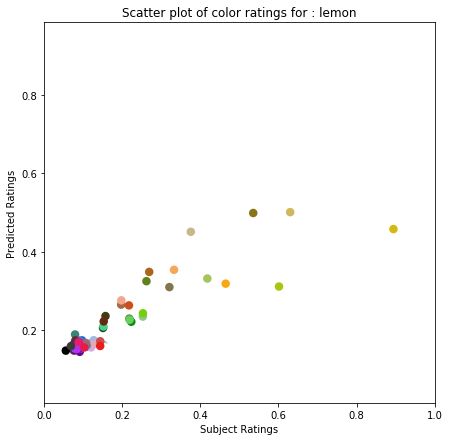

In [11]:
# Sparse features from Analysis III
minErrFeature3 = (54, 179, 180)
errSphCylCat, corrSphCylCat,  win0_m3, win1_m3, win2_m3 = getRatings(minErrFeature3)

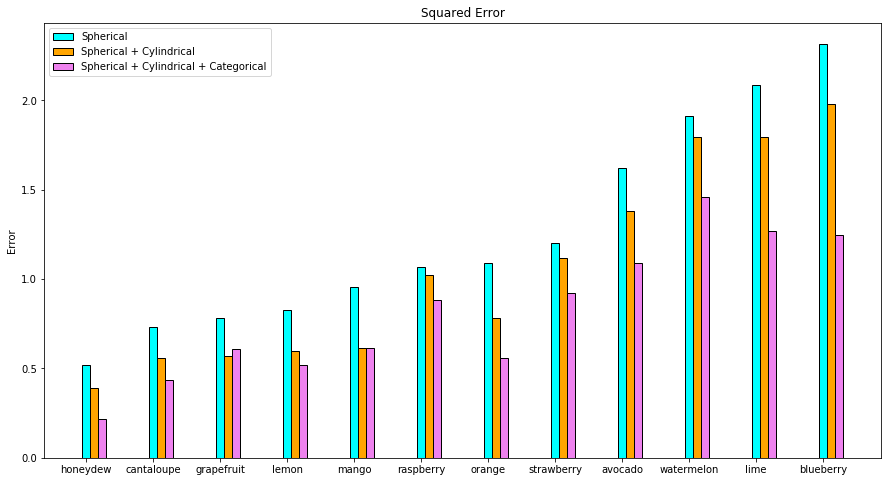

In [12]:
temp  = errSph[:]
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(errSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[errSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[errSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Squared Error")
plt.ylabel('Error')
plt.legend()
#plt.savefig('ErrWithIncreasingRadial.pdf')
plt.show()

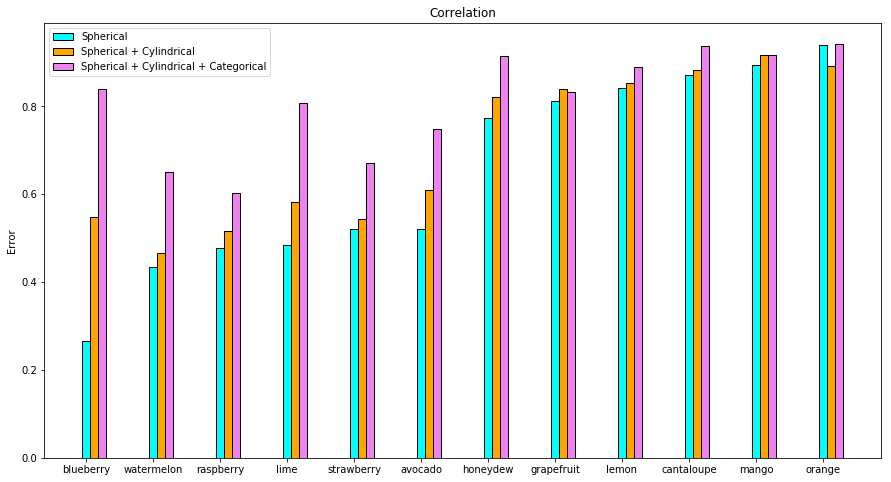

In [13]:
temp  = corrSph[:]
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
plt.close('all')
#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(corrSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[corrSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[corrSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Correlation")
plt.ylabel('Error')
plt.legend()
#plt.savefig('CorrWithIncreasingRadial.eps')
plt.show()

In [14]:
# # For plots of correlations
# err, corr, win0, win1, win2 = getRatings(minErrFeature3, True)

# Figure2: Scatter plots for the best model

In [15]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 9})
def createScatterPlots(indices, win0, win1, win2,model_num):
    print("----------------------- Creating plots for Model ---------------",model_num)
    # print(indices)
    # print(win0)
    
    k = 1
    plt.close('all')

    plt.subplots(3,4,figsize=(10,10))
    for i in range(len(indices)-1,-1,-1):
        # Scatter plot

        arg = indices[i]
        trueRating = win1[arg]
        avg_pred = win2[arg]

        ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
        #ax = f.add_subplot(3,4,k)
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        if k == 1 or k == 5 or k == 9:
            plt.ylabel('Mean Predicted Rating')
        plt.xlabel('Mean Rating')
        s = allConcepts[arg]+"( %.2f )" %win0[arg]
        #print(s)
        plt.title(s)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
        k = k+1
    plotName = "Photo50_ScatterPlot_Model_"+str(model_num)+".pdf"
    plt.savefig(plotName)
    plt.show()
    
    

----------------------- Creating plots for Model --------------- 1


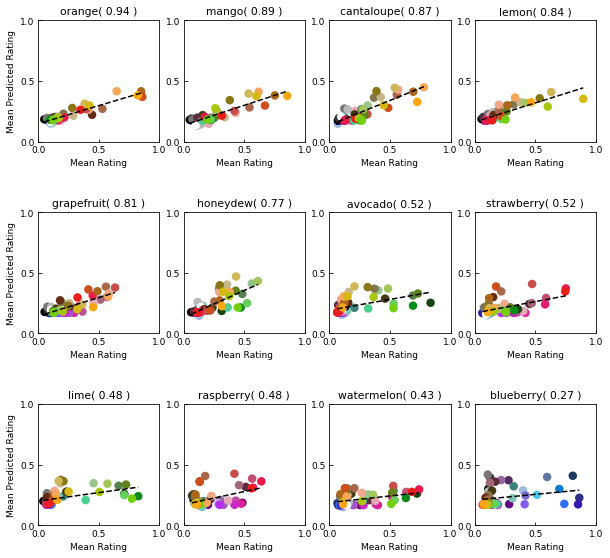

----------------------- Creating plots for Model --------------- 2


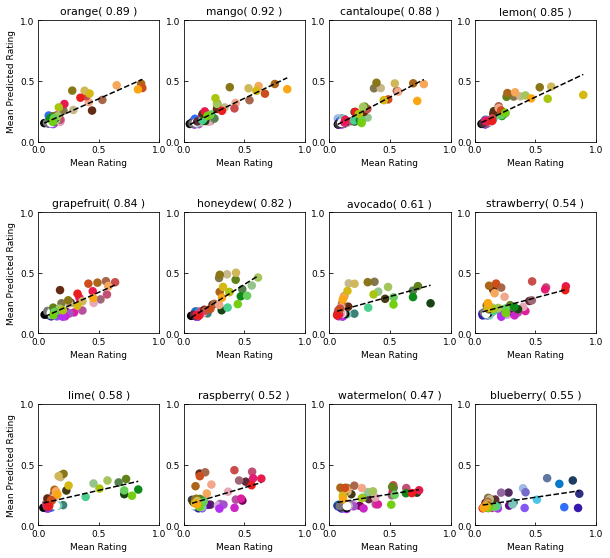

----------------------- Creating plots for Model --------------- 3


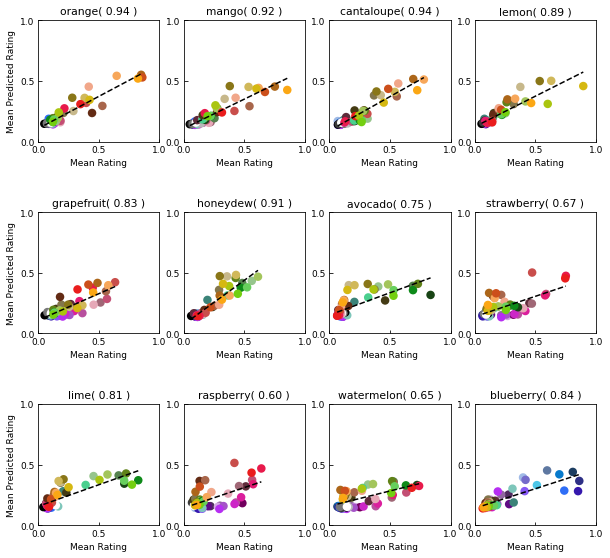

In [16]:
indices = np.argsort(win0_m1) # Want in the order of model 1 correlations
createScatterPlots(indices, win0_m1, win1_m1, win2_m1,1)
createScatterPlots(indices, win0_m2, win1_m2, win2_m2,2)
createScatterPlots(indices,win0_m3, win1_m3, win2_m3,3)

In [17]:
# indices = np.argsort(win0_m3)
# print(indices)
# print(win0_m3)

In [18]:
# k = 1
# plt.close('all')
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 9})
# plt.subplots(3,4,figsize=(10,10))
# for i in range(len(indices)-1,-1,-1):
#     # Scatter plot
    
#     arg = indices[i]
#     trueRating = win1_m3[arg]
#     avg_pred = win2_m3[arg]
    
#     ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
#     #ax = f.add_subplot(3,4,k)
#     plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
#     if k == 1 or k == 5 or k == 9:
#         plt.ylabel('Mean Predicted Rating')
#     plt.xlabel('Mean Rating')
#     s = allConcepts[arg]+"( %.2f )" %win0_m3[arg]
#     #print(s)
#     plt.title(s)
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.yticks([0,0.5,1])
#     plt.xticks([0,0.5,1])
#     plt.tick_params(direction='in')
#     plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
#     k = k+1
# plt.savefig('ScatterPlotBestModel.pdf')
# plt.show()

In [19]:
cor_m3,_ = stats.pearsonr(np.array(win2_m3).flatten(), np.array(win1_m3).flatten())
cor_m2,_ = stats.pearsonr(np.array(win2_m2).flatten(), np.array(win1_m2).flatten())
cor_m1,_ = stats.pearsonr(np.array(win2_m1).flatten(), np.array(win1_m1).flatten())

In [20]:
[cor_m1, cor_m2, cor_m3]

[0.6239519910870299, 0.6916688666099062, 0.8015761152353675]

In [21]:
ratingsPhoto = np.column_stack((np.array(win2_m1).flatten(), np.array(win2_m2).flatten(), np.array(win2_m3).flatten()))

In [22]:
# df = pd.DataFrame(ratingsPhoto)
# ## save to xlsx file

# filepath = 'RatingsPhoto.csv'
# df.to_csv(filepath, index=False)


In [23]:
print("For PHOTO 50")
print("model 1:", cor_m1)
print("model 2:",cor_m2)
print("model :3",cor_m3)


For PHOTO 50
model 1: 0.6239519910870299
model 2: 0.6916688666099062
model :3 0.8015761152353675


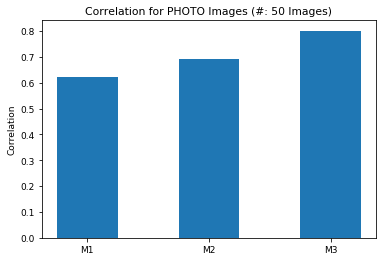

In [22]:
barWidth = 0.5
plt.bar(range(1,4),[cor_m1, cor_m2, cor_m3], width = barWidth)
plt.xticks(range(1,4),['M1','M2','M3'])
plt.title("Correlation for PHOTO Images (#: 50 Images)")
plt.ylabel('Correlation')
plt.show()

# Figure 3: Error and Correlation stem plots for #Images: 50

In [23]:
# temp  = errSph
# print(np.argsort(temp))
# indices = np.flipud(np.argsort(temp))
# indices

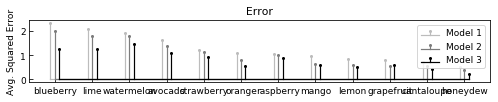

In [24]:
plt.close('all')
temp  = errSph[:]
indices = np.flipud(np.argsort(temp)) # Sort and get indices and reverse order
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize =(7,1.5)) # (12,6)
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
mline1 = plt.stem(r1,sorted(errSph)[::-1], linefmt='-',label='Model 1')
plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.2, markersize = 2)
#plt.setp(sline1, linewidth=0.8)


mline2 = plt.stem(r2,[errSphCyl[t] for t in indices],label='Model 2')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.2, markersize = 2)

mline3 = plt.stem(r3,[errSphCylCat[t] for t in indices],label='Model 3')
plt.setp(mline3, color=[0,0,0], linewidth=1.2, markersize = 2)

plt.xticks(r2,label)
plt.tick_params(direction='in')
plt.title("Error")
plt.ylabel('Avg. Squared Error')
plt.legend()
plt.tight_layout()
plt.savefig('ErrorPhoto50_AllModels.pdf')
plt.show()

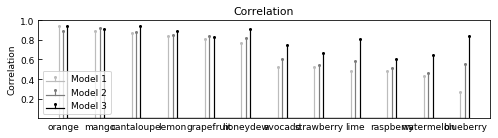

In [25]:
plt.close('all')
temp  = corrSph[:]
indices = np.flipud(np.argsort(temp)) # Sort and get indices and reverse order
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

fig = plt.figure(figsize =(7,2))
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
mline1 = plt.stem(r1,sorted(corrSph)[::-1], linefmt='-',label='Model 1')
plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.2, markersize = 2)

mline2 = plt.stem(r2,[corrSphCyl[t] for t in indices],label='Model 2')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.2, markersize = 2)

mline3 = plt.stem(r3,[corrSphCylCat[t] for t in indices],label='Model 3')
plt.setp(mline3, color=[0,0,0], linewidth=1.2, markersize = 2)

plt.xticks(r2,label)
plt.yticks([0.2, 0.4,0.6, 0.8, 1])
plt.tick_params(direction='in')
plt.title("Correlation")
plt.ylabel('Correlation')
plt.legend()
plt.ylim(0,1)

plt.tight_layout() 
plt.savefig('CorrelationPhoto50_AllModels.pdf')
plt.show()

# Plot for Lemon Lime Blueberry

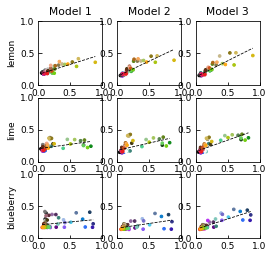

In [26]:
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']
ind1 = 11 #Lemon
ind2 = 10 # Lime
ind3 = 7 # Blueberry
plt.close('all')
k = 1
title = ['Model 1', 'Model 2', 'Model 3']
plt.subplots(3,3,figsize=(4,4))
for i in range(3):
    # Scatter plot
    if i == 0:
        ind = 11
    elif i == 1:
        ind = 10
    else:
        ind = 7
    
    for j in range(3):
        if j == 0:
            trueRating = np.copy(win1_m1[ind])
            avg_pred =np.copy( win2_m1[ind])
        elif j == 1:
            trueRating = np.copy(win1_m2[ind])
            avg_pred = np.copy(win2_m2[ind])
        else:
            trueRating = np.copy(win1_m3[ind])
            avg_pred = np.copy(win2_m3[ind])

        ax = plt.subplot(3,3,k,aspect='equal') #plt.figure(figsize=(7,7))
        plt.scatter(trueRating, avg_pred,c=colorDataRGB.values,marker = 'o',s = 7)
        if k == 1 or k == 4 or k == 7:
            plt.ylabel(allConcepts[ind])
#         plt.xlabel('Mean Rating')
    #     s = allConcepts[arg]+"( %.2f )" %win0[arg]
    #     #print(s)
    #     plt.title(s)
        if k in [1,2,3]:
            plt.title(title[k-1])
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--',linewidth=0.8)
        k = k+1
#plt.tight_layout() 
plt.savefig('LemonLimeBlueberry_ScatterPlotPhoto50.pdf')
plt.show()

In [30]:
print("model 1:",np.mean(errSph))
print("model 2:",np.mean(errSphCyl))
print("model 3:",np.mean(errSphCylCat))

model 1: 1.260007989687656
model 2: 1.0506127632330335
model 3: 0.8181126148135345


In [34]:
print(errSphCylCat)

[0.6125376306024457, 1.457460375474969, 0.2198169726356119, 0.43384889263326765, 0.6092605353921863, 0.9215425034358441, 0.8830340841615568, 1.2462867919219691, 1.0883957817000114, 0.5569844562944914, 1.2693667305280274, 0.5188166229820306]
